In [1]:
import string
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import gensim 
import fasttext

from sklearn.decomposition import PCA
from gensim.models import FastText as FT_gensim
from gensim.test.utils import datapath
from gensim.models.wrappers import FastText as FT

%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("../dataset_gabungan.xlsx")
df

,label,komentar
0,positif,Oke pak boss!!
1,negatif,Jangan dusta
2,positif,PROBOWO is the WINNER of PEMILU 2014
3,netral,ilmu padi
4,positif,Hidup Pak Prabowo ..
...,...,...
5457,netral,bukan saya yang tidak-mau merit sat ini hubung...
5458,netral,Baru lihat kabar Teman nge gosip dan penuh inf...
5459,netral,Mengubah kebiasaan seseorang yg kurang baik it...
5460,netral,nah diam lebih bagus yaudah saya diam saja deh...


In [3]:
df['label'].value_counts()

positif    2912
negatif    1433
netral     1117
Name: label, dtype: int64

In [4]:
komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

komentar

0                                        [oke, pak, boss]
1                                         [jangan, dusta]
2                  [probowo, is, the, winner, of, pemilu]
3                                            [ilmu, padi]
4                                   [hidup, pak, prabowo]
                              ...                        
5457    [bukan, saya, yang, tidakmau, merit, sat, ini,...
5458    [baru, lihat, kabar, teman, nge, gosip, dan, p...
5459    [mengubah, kebiasaan, seseorang, yg, kurang, b...
5460    [nah, diam, lebih, bagus, yaudah, saya, diam, ...
5461    [ya, allah, hanya, engkau, yang, mengetahui, r...
Name: komentar, Length: 5462, dtype: object

In [5]:
model_gensim = FT_gensim(size=300, 
                         negative=5, 
                         min_count=1, 
                         min_n=2, 
                         max_n=3, 
                         sg=0, 
                         sorted_vocab=1, 
                         word_ngrams=1, 
                         window=5, 
                         callbacks=(),
                         ns_exponent=0.75, 
                         cbow_mean=0, 
                         workers=5, 
                         alpha=0.1, 
                         min_alpha=0.025)

In [6]:
model_gensim.build_vocab(komentar)

In [7]:
total_examples = model_gensim.corpus_count
model_gensim.train(
    sentences=komentar,
    total_examples=total_examples, 
    epochs = 100
)

In [8]:
model_gensim.save('XGB.bin')
loaded_model = FT_gensim.load('XGB.bin')

In [9]:
loaded_model.wv.similarity("bagus", "buruk")

0.24600874

In [10]:
loaded_model.wv.distance("bagus", "jelek")

0.7639490813016891

In [11]:
loaded_model.wv.most_similar(positive="jelek", topn=5)

[('jek', 0.8390575647354126),
 ('elek', 0.8388317823410034),
 ('dijelekjelekkan', 0.8347678184509277),
 ('menjelek', 0.830977737903595),
 ('jelekan', 0.825599193572998)]

In [12]:
loaded_model.wv.most_similar_cosmul(positive="bagus", negative=None, topn=5)

[('agus', 0.9124596118927002),
 ('bagusnya', 0.9032562971115112),
 ('baguslah', 0.8988000154495239),
 ('tokobagus', 0.8922543525695801),
 ('bagusan', 0.8805754780769348)]

In [13]:
similar_words = {search_term: [item[0] for item in loaded_model.wv.most_similar([search_term], topn=5)]
                for search_term in ['mantap', 'keren', 'bagus', 'jelek', 'parah', 'cepat']}
similar_words

{'mantap': ['mantapp', 'mantappp', 'mantappop', 'mantapppz', 'mantaappp'],
 'keren': ['kerenn', 'kerenz', 'kerennn', 'kerennnn', 'kerena'],
 'bagus': ['agus', 'bagusnya', 'baguslah', 'tokobagus', 'bagusan'],
 'jelek': ['jek', 'elek', 'dijelekjelekkan', 'menjelek', 'jelekan'],
 'parah': ['parahh', 'parahu', 'pasrah', 'terparah', 'parahnya'],
 'cepat': ['cepatcepat', 'crpat', 'secepat', 'cepatkan', 'tepat']}

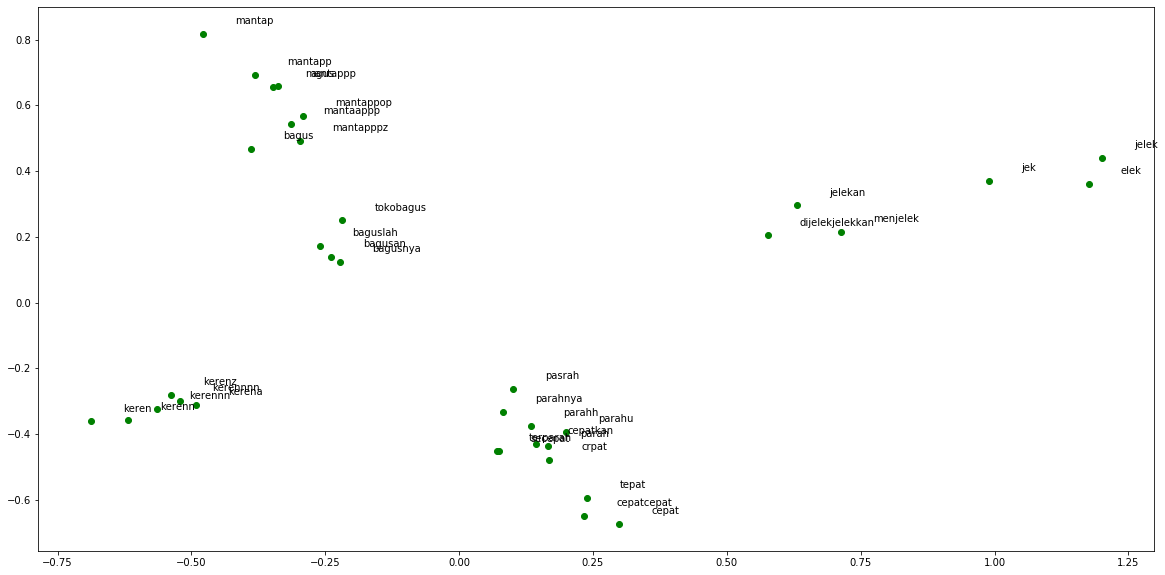

In [14]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = loaded_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(20, 10))
plt.scatter(P[:, 0], P[:, 1], c='green', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')